In [3]:
#import necessary libraries

import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import unidecode
import html

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix


from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model

# Apple Tweet Sentiment Analysis
## Modeling Notebook

Author: Dylan Dey

The Author can be reached at the following email: ddey2985@gmail.com

Blog: [Quick BERT Pre-Trained Model for Sentiment Analysis with Scikit Wrapper](https://dev.to/ddey117/quick-bert-pre-trained-model-for-sentiment-analysis-with-scikit-wrapper-3jcp)

#### Classification Metric Understanding
![Matrix_Understanding](images/Apple_Twitter_matrix_explained.jpg)

#### Confusion Matrix Description

There will always be some error involved in creating a predictive model. The model will incorrectly identify positive tweets as negative and vice versa. That means the error in any classification model in this context can be described by ratios of true positives or negatives vs false positives or negatives.


Correctly predicting a tweet to have negative sentiment is at the heart of the model, as this is the situation in which a company would have a call to action. An appropriately identified tweet with negative sentiment can be properly examined using some simple NLP techniques to get a quick buy effective way to view what is upsetting customers about the company it's products.

Correctly predicting a tweet to have positive sentiment is also important. Word frequency analysis can be used to summarize what consumers think Apple is doing right and also what consumers like about Apple's competitors. 

A false positive would occur when the model incorrectly identifies a tweet containing negative sentiment as a tweet that contains positive sentiment. Given the context of the business model, this would mean more truly negative sentiment will be left out of analyzing key word pairs for negative tweets. This could be interpreted as loss in analytical ability for what we care about most given the buisness problem: making informed decisions from information directly from consumers in the form of social media text. Minimizing false positives is important.

False negatives are also important to consider. A false negative would occur when the model incorrectly identifies a tweet that contains positive sentiment as one that contains negative sentiment. Given the context of the business problem, this would mean extra noise added to the data when trying to isolate for negative sentiment of brand/product. 

In summary, overall accuracy of the model and a reduction of both false negatives and false positives are the most important metrics to consider when developing the sentiment analyisis model. 

##### MVP Metric
[balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

From the documentation: 

"The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class."

This is a great metric for this problem as optimizing for the average of recall for each class will give the best performance given the context of the buisness problem. 

### Function Definition

In [35]:
#list of all functions for modeling
#and processing

#force lowercase of text data
def lower_case_text(text_series):
    text_series = text_series.apply(lambda x: str.lower(x))
    return text_series

#remove URL links from text
def strip_links(text):
    link_regex = re.compile('((https?):((\/\/)|(\\\\))+([\w\d:#@%\/;$()~_?\+-=\\\.&](#!)?)*)|{link}/gm')
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

#remove '@' and '#' symbols from text
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

#tokenize text and remove stopwords
def process_text(text):
    tokenizer = TweetTokenizer()
    
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    my_stop = ["#sxsw",
               "sxsw",
               "sxswi",
               "#sxswi's",
               "#sxswi",
               "southbysouthwest",
               "rt",
               "tweet",
               "tweet's",
               "twitter",
               "austin",
               "#austin",
               "link",
               "1/2",
               "southby",
               "south",
               "texas",
               "@mention",
               "ï",
               "ï",
               "½ï",
               "¿",
               "½",
               "link", 
               "via", 
               "mention",
               "quot",
               "amp",
               "austin"
              ]

    stopwords_list +=  my_stop 
    
    tokens = tokenizer.tokenize(text)
    stopwords_removed = [token for token in tokens if token not in stopwords_list]
    return stopwords_removed
    


#master preprocessing function
def Master_Pre_Vectorization(text_series):
    text_series = lower_case_text(text_series)
    text_series = text_series.apply(strip_links).apply(strip_all_entities)
    text_series = text_series.apply(unidecode.unidecode).apply(html.unescape)
    text_series =text_series.apply(process_text)
    lemmatizer = WordNetLemmatizer()
    text_series = text_series.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return text_series.str.join(' ').copy()


#function for intepreting results of models
#takes in a pipeline and training data
#and prints cross_validation scores 
#and average of scores
#It also returns balanced_accuracy_score

def cross_validation_plus(pipeline, X_train, y_train, X_test, y_test):
    scores = cross_val_score(pipeline, X_train, y_train)
    agg_score = np.mean(scores)
    print(f'{pipeline.steps[1][1]}: Average cross validation score is {agg_score}.')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f'{pipeline.steps[1][1]}: Balanced accuracy score is {balanced_accuracy}.')
    print("------------------------------------")


#function to fit pipeline
#and return subplots 
#that show normalized and 
#regular confusion matrices
#to easily intepret results
def plot_confusion_matrices(pipe, pathway):
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)

    matrix_norm = confusion_matrix(y_test, y_pred, normalize='true') 
    matrix = confusion_matrix(y_test, y_pred) 

    fig, (ax1, ax2) = plt.subplots(ncols = 2,figsize=(10, 5))
    sns.heatmap(matrix_norm,
                annot=True, 
                fmt='.2%', 
                cmap='YlGn',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax1)
    sns.heatmap(matrix,
                annot=True, 
                cmap='YlGn',
                fmt='d',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax2)
    
    plt.savefig(pathway)
    
    plt.show();
    


    
#loads a fitted model from memory 
#returns confusion matrix and
#returns normalized confusion matrix
#calculated using given test data
def confusion_matrix_bert_plots(model_path, X_test, y_test, fig_pathway):
    
    model = load_model(model_path)
    
    y_pred = model.predict(X_test)

    matrix_norm = confusion_matrix(y_test, y_pred, normalize='true')

    matrix = confusion_matrix(y_test, y_pred)

    fig, (ax1, ax2) = plt.subplots(ncols = 2,figsize=(10, 5))
    sns.heatmap(matrix_norm,
                annot=True, 
                fmt='.2%', 
                cmap='YlGn',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax1)
    sns.heatmap(matrix,
                annot=True, 
                cmap='YlGn',
                fmt='d',
                xticklabels=['Pos_predicted', 'Neg_predicted'],
                yticklabels=['Positive Tweet', 'Negative_Tweet'],
                ax=ax2)
    
    plt.savefig(fig_pathway);
    plt.show();

In [36]:
#import cleaned dataset
df = pd.read_csv('data/clean_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# X = df['tweet'].str.join(' ').copy()
X = df['tweet'].copy()
y = df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#clean and prepare data
#for TF_IDF vector transformation
X_train = Master_Pre_Vectorization(X_train)
X_test = Master_Pre_Vectorization(X_test)

#vecorize text data
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

In [37]:
vectorizer = TfidfVectorizer()

#multinomial bayes classifier
nb_classifier = MultinomialNB()
NB_pipe = make_pipeline(vectorizer, nb_classifier)
cross_validation_plus(NB_pipe, X_train, y_train, X_test, y_test)

#random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_pipe = make_pipeline(vectorizer, rf_classifier)
cross_validation_plus(rf_pipe, X_train, y_train, X_test, y_test)

#balanced random forest classifier
balanced_rf_classifier = BalancedRandomForestClassifier(n_estimators=100)
balanced_rf_pipe = make_pipeline(vectorizer, balanced_rf_classifier)
cross_validation_plus(balanced_rf_pipe, X_train, y_train, X_test, y_test)

#XGBoosted classifier
xgb_classifier = XGBClassifier()
xgb_pipe = make_pipeline(vectorizer, xgb_classifier)
cross_validation_plus(xgb_pipe, X_train, y_train, X_test, y_test)

MultinomialNB(): Average cross validation score is 0.8134146341463415.
MultinomialNB(): Balanced accuracy score is 0.7062083711377911.
------------------------------------
RandomForestClassifier(): Average cross validation score is 0.8689024390243902.
RandomForestClassifier(): Balanced accuracy score is 0.7883266867821549.
------------------------------------
BalancedRandomForestClassifier(): Average cross validation score is 0.8408536585365853.
BalancedRandomForestClassifier(): Balanced accuracy score is 0.8146737563212569.
------------------------------------
XGBClassifier(): Average cross validation score is 0.8033536585365854.
XGBClassifier(): Balanced accuracy score is 0.6364406839265996.
------------------------------------


In [38]:
pipes = [NB_pipe,
         rf_pipe,
         balanced_rf_pipe,
         xgb_pipe
        ]

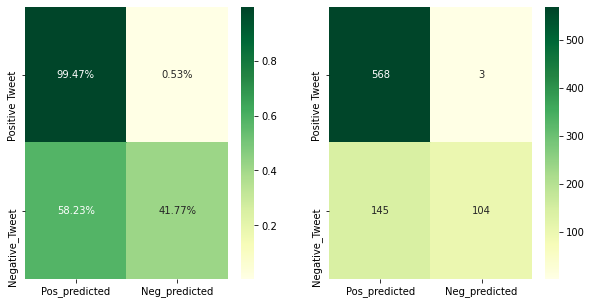

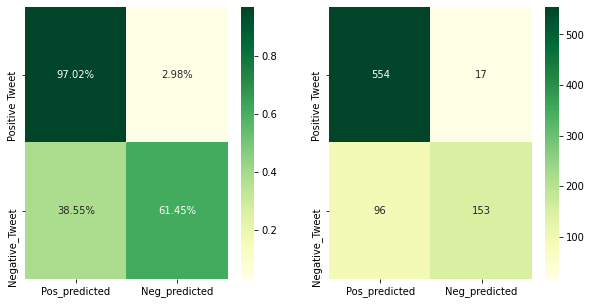

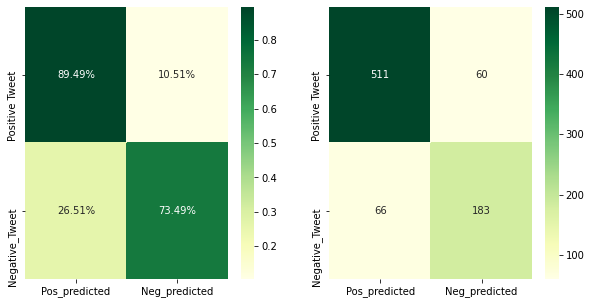

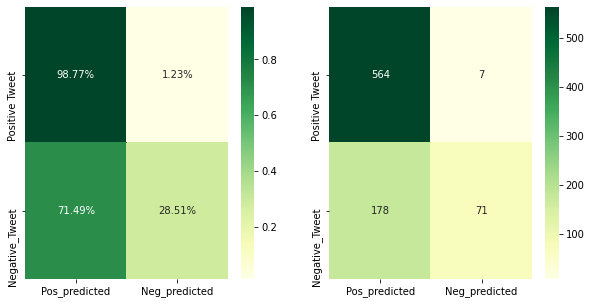

In [39]:
pathways = ['images/XGBoosted_matrix',
            'images/balanced_RF_matrix',
            'images/RF_matrix', 
            'images/NB_matrix'
           ]


for pipe in pipes:
    pathway = pathways.pop()
    plot_confusion_matrices(pipe, pathway)   

Fitting 3 folds for each of 1667 candidates, totalling 5001 fits
BalancedRandomForestClassifier(criterion='entropy', max_depth=340,
                               min_samples_split=8, n_estimators=94): Average cross validation score is 0.8408536585365853.
BalancedRandomForestClassifier(criterion='entropy', max_depth=340,
                               min_samples_split=8, n_estimators=94): Balanced accuracy score is 0.81194128528123.
------------------------------------


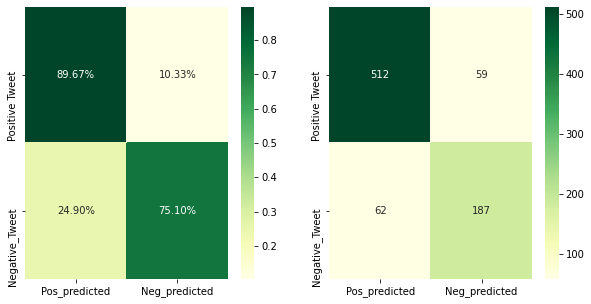

In [41]:
#initialize grid search variables
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
criterion = ["gini", "entropy"]
min_samples_split = [8, 10, 12]
max_depth = [int(x) for x in np.linspace(10, 1000, num = 10)] 
min_samples_leaf = [0.01, 0.1, 1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

#rrandomly iterate 1667*3 times through the grid
balanced_rfc_rs = RandomizedSearchCV(estimator = BalancedRandomForestClassifier(), 
                                     param_distributions = random_grid,
                                     scoring = 'balanced_accuracy',
                                     n_iter = 1667,
                                     cv = 3,
                                     verbose=2,
                                     random_state=11,
                                     n_jobs = -1
                                    )


#fit random grid search and determine best_estimator_
balanced_rfc_rs.fit(tf_idf_X_train, y_train)

#create pipeline for best result from random grid search
balanced_rfc_rs_pipe = make_pipeline(vectorizer, 
                                     balanced_rfc_rs.best_estimator_)

cross_validation_plus(balanced_rfc_rs_pipe, X_train, y_train, X_test, y_test)
plot_confusion_matrices(balanced_rfc_rs_pipe, 'images/best_balanced_rf_matrix.jpg')

Now that supervised learning models have been built, trained, and tuned without being pre-trained on any other data, our focus will now turn to transfer learning using Bidirectional Encoder Representations from Transformers(BERT), developed by Google. BERT is a transformer-based machine learning technique for natural language processing pre-training. BERTBASE models are pre-trained from unlabeled data extracted from the BooksCorpus with 800M words and English Wikipedia with 2,500M words. For this project, a BERT_base model will be trained (110 million parameters in the core of the network). Results of tuning a BERT_large model will be added as future work.

A really interesting and succinct blog by Author Rani Horev about [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) briefly covers the architecture and capabilities of this massive pre-trained model. 

[Click Here for more from Wikipedia](https://en.wikipedia.org/wiki/BERT_(language_model))

[GitHub for BERT release code](https://github.com/google-research/bert)

Sckit-learn wrapper provided by Charles Nainan. [GitHub of Scikit Learn BERT wrapper](https://github.com/charles9n/bert-sklearn). 


This scikit-learn wrapper is used to finetune Google's BERT model and is built on the huggingface pytorch port. 

Below is the documentation for Hugging Face Trnsformers. Taken from the website: "Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides thousands of pretrained models to perform tasks on different modalities such as text, vision, and audio."
[Hugging Face Transformers](https://huggingface.co/docs/transformers/index)

In [9]:
"""
The first model was fitted as seen commeted out below 
after some trial and error to determine an appropriate
max_seq_length given my computer's capibilities. 

"""


# bert_1 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50
#                      )



"""
My second model contains 2 hidden layers with 600 neurons. 
It only passes over the corpus one time when learning.
It trains fast and gives impressive results.

"""


# bert_2 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50,
#                       num_mlp_hiddens=500,
#                       num_mlp_layers=2,
#                       epochs=1
#                      )

"""
My third bert model has 600 neurons still but
only one hidden layer. However, the model
passes over the corpus 4 times in total
while learning.

"""

# bert_3 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50,
#                       num_mlp_hiddens=600,
#                       num_mlp_layers=1,
#                       epochs=4
#                      )

"""
My fourth bert model has 750 neurons and 
two hidden layers. The corpus also gets
transversed four times in total while 
learning.

"""

# bert_4 = BertClassifier(do_lower_case=True,
#                       train_batch_size=32,
#                       max_seq_length=50,
#                       num_mlp_hiddens=750,
#                       num_mlp_layers=2,
#                       epochs=4
#                      )

'\nMy fourth bert model has 750 neurons and \ntwo hidden layers. The corpus also gets\ntransversed four times in total while \nlearning.\n\n'

Loading model from data/bert_model_1.bin...


02/09/2022 21:58:35 - INFO - bert_sklearn.model.pytorch_pretrained.modeling -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



Defaulting to linear classifier/regressor
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


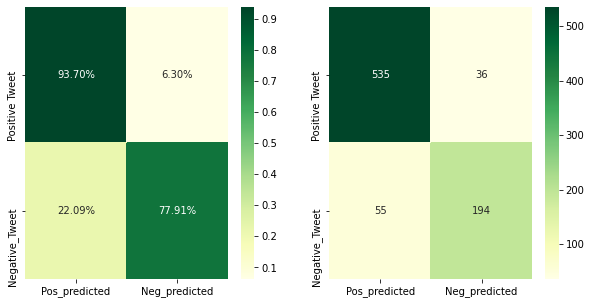

Loading model from data/bert_model_2.bin...
Using mlp with D=768,H=500,K=2,n=2
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


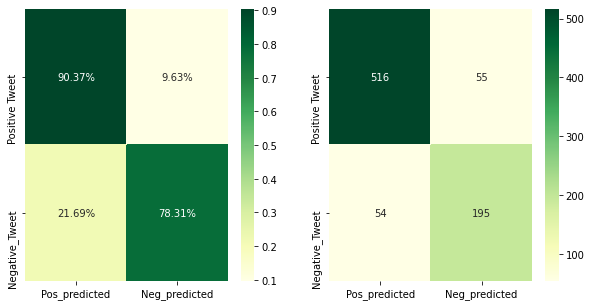

Loading model from data/bert_model_3.bin...
Using mlp with D=768,H=600,K=2,n=1
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


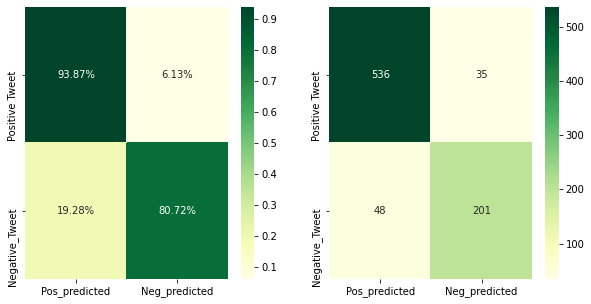

Loading model from data/bert_model_4.bin...
Using mlp with D=768,H=750,K=2,n=2
Building sklearn text classifier...


Predicting: 100%|██████████| 103/103 [01:26<00:00,  1.19it/s]


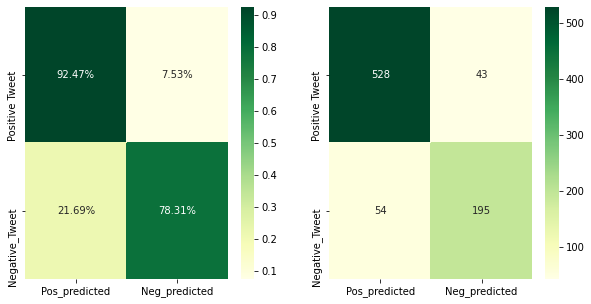

In [11]:
#Review confusion matrix plots
#For all bert models saved in memory

bert_paths= ['data/bert_model_1.bin', 
             'data/bert_model_2.bin', 
             'data/bert_model_3.bin',
             'data/bert_model_4.bin'
            ]

figure_paths = ['images/bert4_matrix.jpg',
                'images/bert3_matrix.jpg',
                'images/bert2_matrix.jpg',
                'images/bert1_matrix.jpg',
               ]

for bert_path in bert_paths:
    figure_path = figure_paths.pop()
    confusion_matrix_bert_plots(bert_path, X_test, y_test, figure_path)

## Evaluation

The best performing model was the  BERT Classifier with 4 epochs, one hidden layer, and 600 neurons. This classifier was able to correctly predict over 80% of negative tweets correctly, which is really impressive given the imbalance in the original data. It also correctly identifies positive tweets nearly 94% of the time.


##### Balanced Random Forest Confusion Matrix
![Bert3_Matrix](images/bert3_matrix.jpg)


While the BERT classifier performed the best, the balanced random forest classifier has moderate predictive abilities using sparse vectors.   

##### Balanced Random Forest Confusion Matrix
![Balanced_RandomForest_Matrix](images/best_balanced_rf_matrix.jpg)


## Conclusions 

- Either classifier could be used to predict sentiment on new brand-centric social media data for the company's own products or that of a competitor.

### Future Work

- Use the BERT classifier to predict the sentiment on new unlabeled twitter data filtered for product or brand of interest (Apple/Google) from another source to find more actionable insights to further proof of concept.


- Use the BERT classifier to predict the sentiment on new twitter data to help balance existing dataset and retrain the other models.

- leverage a state-of-the-art early stopping algorithm (ASHA) using Ray Tune and PyTorch.(1)(2)

(1)Author Amog Kamsetty explores the importance of hyperparameter tuning in his blog [Hyperparameter Optimization for Transformers: A guide
](https://medium.com/distributed-computing-with-ray/hyperparameter-optimization-for-transformers-a-guide-c4e32c6c989b). [This Colobrative Notebook](https://colab.research.google.com/drive/1tQgAKgcKQzheoh503OzhS4N9NtfFgmjF?usp=sharing) shared in the blog is a good starting point to try optimize with Ray Tune. 

(2)Author Richard Liaw shares a blog that shows how simple it is to leverage all of the cores and GPUs on your machine to perform parallel asynchronous hyperparameter tuning and how to launch a massive distributed hyperparameter search on the cloud (and automatically shut down hardware after completion). [Ray Tune: a Python library for fast hyperparameter tuning at any scale](https://towardsdatascience.com/fast-hyperparameter-tuning-at-scale-d428223b081c) also showcases a lot of exciting algorithms to explore when tuning models. 